# Cross Entropy Benchmarking (XEB)


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/apps/supermarq/qcvv/qcvv_xeb_css.ipynb)
[![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/apps/supermarq/qcvv/qcvv_xeb_css.ipynb)


To demonstrate the cross entropy benchmarking routine, consider a noise model with two independent
depolarising channels, one which only effects single qubit gates and a second that only effects two
qubit gates.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# try:
#     import supermarq
# except ImportError:
#     print("Installing supermarq...")
#     %pip install --quiet supermarq
#     print("Installed supermarq.")
#     print("You may need to restart the kernel to import newly installed packages.")

In [3]:
from __future__ import annotations
import cirq
import numpy as np


class IndependentDepolariseNoiseModel(cirq.NoiseModel):
    """Applies single and two qubit depolarising channels independently"""

    def __init__(self, single_qubit_error: float, two_qubit_error: float) -> None:
        """Args:
        single_qubit_error: Single qubit pauli error
        two_qubit_error: Two qubit pauli error
        """
        super().__init__()
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error

        self.single_qubit_depolarise = cirq.DepolarizingChannel(p=single_qubit_error, n_qubits=1)
        self.two_qubit_depolarise = cirq.DepolarizingChannel(p=two_qubit_error, n_qubits=2)

    def noisy_operation(self, operation: cirq.Operation) -> list[cirq.OP_TREE]:
        """Produces a list of operations by applying each noise model
        to the provided operation depending on the number of qubits it acts on.
        """
        if len(operation.qubits) == 1:
            return [operation, self.single_qubit_depolarise(*operation.qubits)]

        if len(operation.qubits) == 2:
            return [operation, self.two_qubit_depolarise(*operation.qubits)]

        return [operation]


noise = IndependentDepolariseNoiseModel(single_qubit_error=0.005, two_qubit_error=0.02)
simulator = cirq.DensityMatrixSimulator(
    noise=noise,
)

The XEB experiment allows us to estimate the fidelity of a "cycle" composed of pair of single qubit
gates followed by a two qubit gate. If each single qubit gate is effected by a pauli error channel
with rate $p_1$ and each two qubit gate is effected by a two qubit depolarising channel with pauli
$p_2$ the overall cycle depolarising error is
$$e_L = \frac{16}{15}\left( 1 - \left(1- p_1\right)^2 \left(1-p_2\right) \right)$$


In [ ]:
from supermarq.qcvv import XEB

experiment = XEB(num_circuits=25, cycle_depths=[1, 10, 50, 100])
results = experiment.run_with_simulator(simulator)

Building circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Estimated cycle fidelity: 0.96778 +/- 0.0001289
Cycle depolarising error: 0.03176
Estimated cycle depolarising error: 0.03222


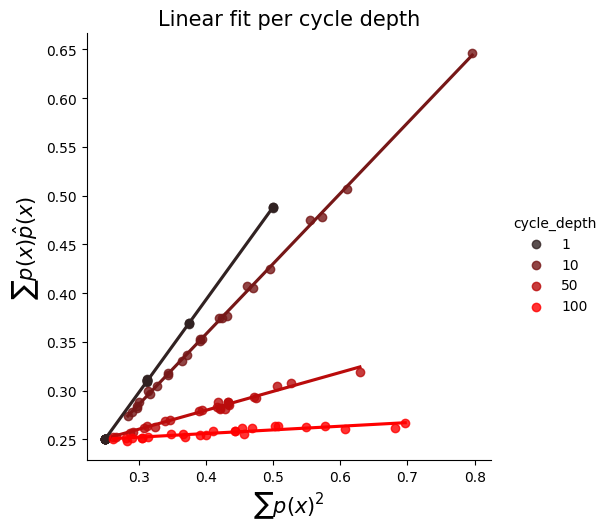

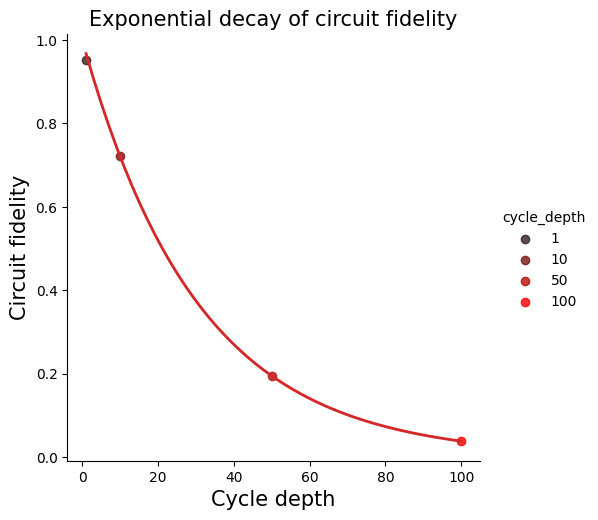

In [5]:
results.analyze_results(plot_results=True)
cycle_depolarising_error = (
    16 / 15 * (1 - (1 - noise.single_qubit_error) ** 2 * (1 - noise.two_qubit_error))
)
cycle_depolarising_error_estimate = 1 - results.cycle_fidelity_estimate
print(f"Cycle depolarising error: {cycle_depolarising_error:.5f}")
print(f"Estimated cycle depolarising error: {cycle_depolarising_error_estimate:.5f}")

Now lets repeat a similar experiment, still using two qubits but this time without entangling gates
between them. In this case our noise model reduces to a pair of independent single qubit
depolarising channels with pauli rates $p_1$, or equivalently depolarising rates of
$e_{1q} = \tfrac34 p_1$.

Each cycle is made up of two single qubit gates (one on each qubit) so we obtain a cycle fidelity of
$$f_L = (1- e_{1q})^2$$

Thus we can estimate the single qubit pauli error as $$p_1 = \frac{4}{3} \left(1-\sqrt{f_L}\right)$$


In [6]:
single_qubit_experiment = XEB(two_qubit_gate=None, num_circuits=25, cycle_depths=[10, 50, 100, 200])
single_qubit_experiment_results = single_qubit_experiment.run_with_simulator(simulator=simulator)

Building circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Estimated cycle fidelity: 0.9919 +/- 0.000199
Single qubit pauli error: 0.00500
Estimated single qubit pauli error: 0.00541


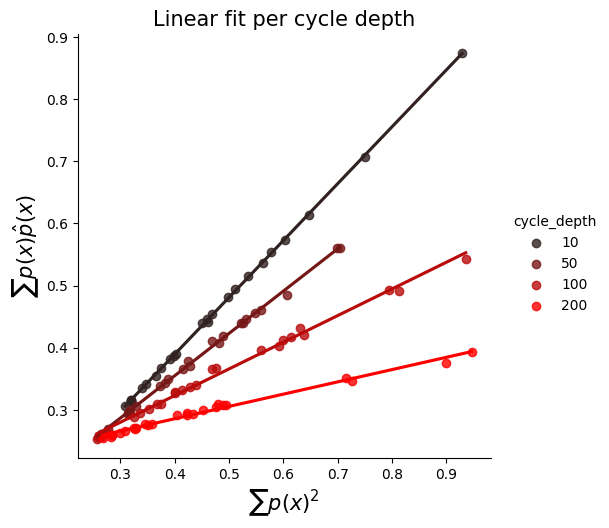

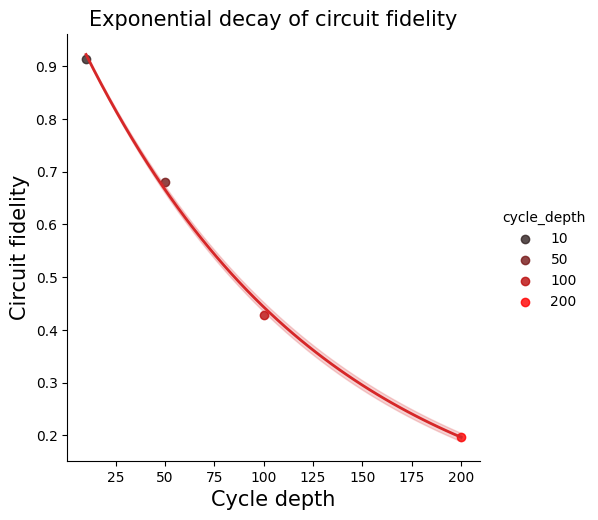

In [7]:
single_qubit_experiment_results.analyze_results(plot_results=True)
single_qubit_pauli_error_estimate = (
    4 / 3 * (1 - np.sqrt(single_qubit_experiment_results.cycle_fidelity_estimate))
)

print(f"Single qubit pauli error: {noise.single_qubit_error:.5f}")
print(f"Estimated single qubit pauli error: {single_qubit_pauli_error_estimate:.5f}")

We can now rearrange the equation above to estimate the two qubit depolarising error $$ e*{2q} =
\frac{16}{15} \left(1 - \frac{1-\tfrac{15}{16}e_L}{\left(1 - \tfrac43 e*{1q}\right)^2} \right)$$


In [8]:
two_qubit_depolarising_error = 16 / 15 * noise.two_qubit_error
two_qubit_depolarising_error_estimate = (16 / 15) * (
    1
    - (
        (1 - 15 / 16 * cycle_depolarising_error_estimate)
        / (1 - single_qubit_pauli_error_estimate) ** 2
    )
)
print(f"Two qubit depolarising error: {two_qubit_depolarising_error:.5f}")
print(f"Estimated two qubit depolarising error: {two_qubit_depolarising_error_estimate:.5f}")

Two qubit depolarising error: 0.02133
Estimated two qubit depolarising error: 0.02094


The final tool we can use as part of XEB is to visualize the decoherence through speckle plots.
These show how the probability of being in a given state transitions from 'speckles' at small
cycle depths to being smoothed out at deeper circuits. For more details see Fig.S18 of https://arxiv.org/pdf/1910.11333. 

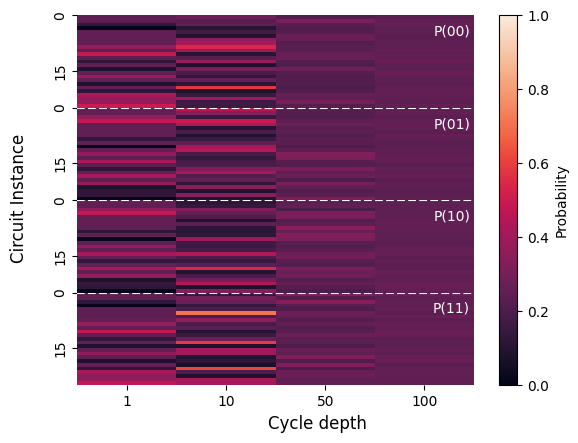

In [ ]:
# Note that these plots look better when more circuit depths have been samples,
# but this example demonstrates the point.
results.plot_speckle()